## Are there specific states with higher or lower fatality rates? What factors might contribute to regional variations?

In [33]:
# Run this cell to authenticate yourself to BigQuery
from google.oauth2 import service_account
key_path = './cs145-project2-406000-9a59fc7c0b3d.json'
credential = service_account.Credentials.from_service_account_file(key_path)

In [2]:
# Initialize BiqQuery client
from google.cloud import bigquery
%load_ext google.cloud.bigquery
%env GOOGLE_APPLICATION_CREDENTIALS=$key_path
project_id = "cs145-project2-406000"
client = bigquery.Client(credentials=credential, project=project_id)

env: GOOGLE_APPLICATION_CREDENTIALS=./cs145-project2-406000-9a59fc7c0b3d.json


## Aggregate our Data into one Table

In [55]:
%%bigquery --project $project_id
CREATE OR REPLACE TABLE traffic_fatalities.traffic_features AS
SELECT
  CONCAT(accident2016.consecutive_number, accident2016.year_of_crash) AS id,    
  accident2016.state_name,
  accident2016.number_of_motor_vehicles_in_transport_mvit,
  accident2016.number_of_parked_working_vehicles,
  accident2016.number_of_persons_in_motor_vehicles_in_transport_mvit,
  accident2016.number_of_persons_not_in_motor_vehicles_in_transport_mvit,
  accident2016.city_name,
  accident2016.day_name,
  accident2016.month_of_crash_name,
  accident2016.day_of_week_name,
  accident2016.hour_of_crash_name,
  accident2016.route_signing_name,
  accident2016.land_use_name,
  accident2016.first_harmful_event_name,
  accident2016.work_zone_name,
  accident2016.relation_to_trafficway_name,
  accident2016.light_condition_name,
  accident2016.atmospheric_conditions_name,
  IF(accident2016.hour_of_notification > 23 OR accident2016.hour_of_arrival_at_scene > 23 OR accident2016.minute_of_arrival_at_scene > 59, 9999, (IF(accident2016.hour_of_notification <= accident2016.hour_of_arrival_at_scene, accident2016.hour_of_arrival_at_scene - accident2016.hour_of_notification, accident2016.hour_of_arrival_at_scene - accident2016.hour_of_notification + 24) * 60 + IF(accident2016.minute_of_notification <= accident2016.minute_of_arrival_at_scene, accident2016.minute_of_arrival_at_scene - accident2016.minute_of_notification, accident2016.minute_of_arrival_at_scene - accident2016.minute_of_notification + 60))) AS time_to_scene,
  IF(accident2016.hour_of_notification > 23 OR accident2016.hour_of_ems_arrival_at_hospital > 23 OR accident2016.minute_of_ems_arrival_at_hospital > 59, 9999, (IF(accident2016.hour_of_notification <= accident2016.hour_of_ems_arrival_at_hospital, accident2016.hour_of_ems_arrival_at_hospital - accident2016.hour_of_notification, accident2016.hour_of_ems_arrival_at_hospital - accident2016.hour_of_notification + 24) * 60 + IF(accident2016.minute_of_notification <= accident2016.minute_of_ems_arrival_at_hospital, accident2016.minute_of_ems_arrival_at_hospital - accident2016.minute_of_notification, accident2016.minute_of_ems_arrival_at_hospital - accident2016.minute_of_notification + 60))) AS time_to_hospital,
  accident2016.number_of_drunk_drivers,
  accident2016.number_of_fatalities,
  2 * accident2016.number_of_motor_vehicles_in_transport_mvit + accident2016.number_of_parked_working_vehicles + 4 * accident2016.number_of_fatalities AS severity,
  IF(2 * accident2016.number_of_motor_vehicles_in_transport_mvit + accident2016.number_of_parked_working_vehicles + 4 * accident2016.number_of_fatalities > 6, 1, 0) AS label,
  distract2016.driver_distracted_by_name,
  drimpair2016.condition_impairment_at_time_of_crash_driver_name,
  factor2016.contributing_circumstances_motor_vehicle_name,
  maneuver2016.driver_maneuvered_to_avoid_name,
  nmcrash2016.non_motorist_contributing_circumstances_name,
  nmimpair2016.condition_impairment_at_time_of_crash_non_motorist_name,
  violatn2016.violations_charged_name,
  vision2016.drivers_vision_obscured_by_name
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2016` AS accident2016
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. distract_2016` AS distract2016 ON accident2016.consecutive_number = distract2016.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. drimpair_2016` AS drimpair2016 ON accident2016.consecutive_number = drimpair2016.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. factor_2016` AS factor2016 ON accident2016.consecutive_number = factor2016.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. maneuver_2016` AS maneuver2016 ON accident2016.consecutive_number = maneuver2016.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. nmcrash_2016` AS nmcrash2016 ON accident2016.consecutive_number = nmcrash2016.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. nmimpair_2016` AS nmimpair2016 ON accident2016.consecutive_number = nmimpair2016.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. violatn_2016` AS violatn2016 ON accident2016.consecutive_number = violatn2016.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. vision_2016` AS vision2016 ON accident2016.consecutive_number = vision2016.consecutive_number
UNION ALL
SELECT 
  CONCAT(accident2017.consecutive_number, accident2017.year_of_crash) AS id,    
  accident2017.state_name, 
  accident2017.number_of_motor_vehicles_in_transport_mvit, 
  accident2017.number_of_parked_working_vehicles, 
  accident2017.number_of_persons_in_motor_vehicles_in_transport_mvit, 
  accident2017.number_of_persons_not_in_motor_vehicles_in_transport_mvit, 
  accident2017.city_name, 
  accident2017.day_name, 
  accident2017.month_of_crash_name, 
  accident2017.day_of_week_name, 
  accident2017.hour_of_crash_name, 
  accident2017.route_signing_name, 
  accident2017.land_use_name, 
  accident2017.first_harmful_event_name, 
  accident2017.work_zone_name, 
  accident2017.relation_to_trafficway_name, 
  accident2017.light_condition_name, 
  accident2017.atmospheric_conditions_name, 
  IF(accident2017.hour_of_notification > 23 OR accident2017.hour_of_arrival_at_scene > 23 OR accident2017.minute_of_arrival_at_scene > 59, 9999, (IF(accident2017.hour_of_notification <= accident2017.hour_of_arrival_at_scene, accident2017.hour_of_arrival_at_scene - accident2017.hour_of_notification, accident2017.hour_of_arrival_at_scene - accident2017.hour_of_notification + 24) * 60 + IF(accident2017.minute_of_notification <= accident2017.minute_of_arrival_at_scene, accident2017.minute_of_arrival_at_scene - accident2017.minute_of_notification, accident2017.minute_of_arrival_at_scene - accident2017.minute_of_notification + 60))) AS time_to_scene,
  IF(accident2017.hour_of_notification > 23 OR accident2017.hour_of_ems_arrival_at_hospital > 23 OR accident2017.minute_of_ems_arrival_at_hospital > 59, 9999, (IF(accident2017.hour_of_notification <= accident2017.hour_of_ems_arrival_at_hospital, accident2017.hour_of_ems_arrival_at_hospital - accident2017.hour_of_notification, accident2017.hour_of_ems_arrival_at_hospital - accident2017.hour_of_notification + 24) * 60 + IF(accident2017.minute_of_notification <= accident2017.minute_of_ems_arrival_at_hospital, accident2017.minute_of_ems_arrival_at_hospital - accident2017.minute_of_notification, accident2017.minute_of_ems_arrival_at_hospital - accident2017.minute_of_notification + 60))) AS time_to_hospital,
  accident2017.number_of_drunk_drivers, 
  accident2017.number_of_fatalities,
  2 * accident2017.number_of_motor_vehicles_in_transport_mvit + accident2017.number_of_parked_working_vehicles + 4 * accident2017.number_of_fatalities AS severity,
  IF(2 * accident2017.number_of_motor_vehicles_in_transport_mvit + accident2017.number_of_parked_working_vehicles + 4 * accident2017.number_of_fatalities > 6, 1, 0) AS label,
  distract2017.driver_distracted_by_name, 
  drimpair2017.condition_impairment_at_time_of_crash_driver_name, 
  factor2017.contributing_circumstances_motor_vehicle_name, 
  maneuver2017.driver_maneuvered_to_avoid_name, 
  nmcrash2017.non_motorist_contributing_circumstances_name, 
  nmimpair2017.condition_impairment_at_time_of_crash_non_motorist_name, 
  violatn2017.violations_charged_name, 
  vision2017.drivers_vision_obscured_by_name
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2017` AS accident2017
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. distract_2017` AS distract2017 ON accident2017.consecutive_number = distract2017.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. drimpair_2017` AS drimpair2017 ON accident2017.consecutive_number = drimpair2017.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. factor_2017` AS factor2017 ON accident2017.consecutive_number = factor2017.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. maneuver_2017` AS maneuver2017 ON accident2017.consecutive_number = maneuver2017.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. nmcrash_2017` AS nmcrash2017 ON accident2017.consecutive_number = nmcrash2017.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. nmimpair_2017` AS nmimpair2017 ON accident2017.consecutive_number = nmimpair2017.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. violatn_2017` AS violatn2017 ON accident2017.consecutive_number = violatn2017.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. vision_2017` AS vision2017 ON accident2017.consecutive_number = vision2017.consecutive_number
UNION ALL
SELECT
  CONCAT(accident2018.consecutive_number, accident2018.year_of_crash) AS id,    
  accident2018.state_name,
  accident2018.number_of_motor_vehicles_in_transport_mvit,
  accident2018.number_of_parked_working_vehicles,
  accident2018.number_of_persons_in_motor_vehicles_in_transport_mvit,
  accident2018.number_of_persons_not_in_motor_vehicles_in_transport_mvit,
  accident2018.city_name,
  accident2018.day_name,
  accident2018.month_of_crash_name,
  accident2018.day_of_week_name,
  accident2018.hour_of_crash_name,
  accident2018.route_signing_name,
  accident2018.land_use_name,
  accident2018.first_harmful_event_name,
  accident2018.work_zone_name,
  accident2018.relation_to_trafficway_name,
  accident2018.light_condition_name,
  accident2018.atmospheric_conditions_name,
  IF(accident2018.hour_of_notification > 23 OR accident2018.hour_of_arrival_at_scene > 23 OR accident2018.minute_of_arrival_at_scene > 59, 9999, (IF(accident2018.hour_of_notification <= accident2018.hour_of_arrival_at_scene, accident2018.hour_of_arrival_at_scene - accident2018.hour_of_notification, accident2018.hour_of_arrival_at_scene - accident2018.hour_of_notification + 24) * 60 + IF(accident2018.minute_of_notification <= accident2018.minute_of_arrival_at_scene, accident2018.minute_of_arrival_at_scene - accident2018.minute_of_notification, accident2018.minute_of_arrival_at_scene - accident2018.minute_of_notification + 60))) AS time_to_scene,
  IF(accident2018.hour_of_notification > 23 OR accident2018.hour_of_ems_arrival_at_hospital > 23 OR accident2018.minute_of_ems_arrival_at_hospital > 59, 9999, (IF(accident2018.hour_of_notification <= accident2018.hour_of_ems_arrival_at_hospital, accident2018.hour_of_ems_arrival_at_hospital - accident2018.hour_of_notification, accident2018.hour_of_ems_arrival_at_hospital - accident2018.hour_of_notification + 24) * 60 + IF(accident2018.minute_of_notification <= accident2018.minute_of_ems_arrival_at_hospital, accident2018.minute_of_ems_arrival_at_hospital - accident2018.minute_of_notification, accident2018.minute_of_ems_arrival_at_hospital - accident2018.minute_of_notification + 60))) AS time_to_hospital,
  accident2018.number_of_drunk_drivers,
  accident2018.number_of_fatalities,
  2 * accident2018.number_of_motor_vehicles_in_transport_mvit + accident2018.number_of_parked_working_vehicles + 4 * accident2018.number_of_fatalities AS severity,
  IF(2 * accident2018.number_of_motor_vehicles_in_transport_mvit + accident2018.number_of_parked_working_vehicles + 4 * accident2018.number_of_fatalities > 6, 1, 0) AS label,
  distract2018.driver_distracted_by_name,
  drimpair2018.condition_impairment_at_time_of_crash_driver_name,
  factor2018.contributing_circumstances_motor_vehicle_name,
  maneuver2018.driver_maneuvered_to_avoid_name,
  nmcrash2018.non_motorist_contributing_circumstances_name,
  nmimpair2018.condition_impairment_at_time_of_crash_non_motorist_name,
  violatn2018.violations_charged_name,
  vision2018.drivers_vision_obscured_by_name
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2018` AS accident2018
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. distract_2018` AS distract2018 ON accident2018.consecutive_number = distract2018.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. drimpair_2018` AS drimpair2018 ON accident2018.consecutive_number = drimpair2018.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. factor_2018` AS factor2018 ON accident2018.consecutive_number = factor2018.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. maneuver_2018` AS maneuver2018 ON accident2018.consecutive_number = maneuver2018.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. nmcrash_2018` AS nmcrash2018 ON accident2018.consecutive_number = nmcrash2018.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. nmimpair_2018` AS nmimpair2018 ON accident2018.consecutive_number = nmimpair2018.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. violatn_2018` AS violatn2018 ON accident2018.consecutive_number = violatn2018.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. vision_2018` AS vision2018 ON accident2018.consecutive_number = vision2018.consecutive_number
UNION ALL
SELECT
  CONCAT(accident2019.consecutive_number, accident2019.year_of_crash) AS id,    
  accident2019.state_name,
  accident2019.number_of_motor_vehicles_in_transport_mvit,
  accident2019.number_of_parked_working_vehicles,
  accident2019.number_of_persons_in_motor_vehicles_in_transport_mvit,
  accident2019.number_of_persons_not_in_motor_vehicles_in_transport_mvit,
  accident2019.city_name,
  accident2019.day_name,
  accident2019.month_of_crash_name,
  accident2019.day_of_week_name,
  accident2019.hour_of_crash_name,
  accident2019.route_signing_name,
  accident2019.land_use_name,
  accident2019.first_harmful_event_name,
  accident2019.work_zone_name,
  accident2019.relation_to_trafficway_name,
  accident2019.light_condition_name,
  accident2019.atmospheric_conditions_name,
  IF(accident2019.hour_of_notification > 23 OR accident2019.hour_of_arrival_at_scene > 23 OR accident2019.minute_of_arrival_at_scene > 59, 9999, (IF(accident2019.hour_of_notification <= accident2019.hour_of_arrival_at_scene, accident2019.hour_of_arrival_at_scene - accident2019.hour_of_notification, accident2019.hour_of_arrival_at_scene - accident2019.hour_of_notification + 24) * 60 + IF(accident2019.minute_of_notification <= accident2019.minute_of_arrival_at_scene, accident2019.minute_of_arrival_at_scene - accident2019.minute_of_notification, accident2019.minute_of_arrival_at_scene - accident2019.minute_of_notification + 60))) AS time_to_scene,
  IF(accident2019.hour_of_notification > 23 OR accident2019.hour_of_ems_arrival_at_hospital > 23 OR accident2019.minute_of_ems_arrival_at_hospital > 59, 9999, (IF(accident2019.hour_of_notification <= accident2019.hour_of_ems_arrival_at_hospital, accident2019.hour_of_ems_arrival_at_hospital - accident2019.hour_of_notification, accident2019.hour_of_ems_arrival_at_hospital - accident2019.hour_of_notification + 24) * 60 + IF(accident2019.minute_of_notification <= accident2019.minute_of_ems_arrival_at_hospital, accident2019.minute_of_ems_arrival_at_hospital - accident2019.minute_of_notification, accident2019.minute_of_ems_arrival_at_hospital - accident2019.minute_of_notification + 60))) AS time_to_hospital,
  accident2019.number_of_drunk_drivers,
  accident2019.number_of_fatalities,
  2 * accident2019.number_of_motor_vehicles_in_transport_mvit + accident2019.number_of_parked_working_vehicles + 4 * accident2019.number_of_fatalities AS severity,
  IF(2 * accident2019.number_of_motor_vehicles_in_transport_mvit + accident2019.number_of_parked_working_vehicles + 4 * accident2019.number_of_fatalities > 6, 1, 0) AS label,
  distract2019.driver_distracted_by_name,
  drimpair2019.condition_impairment_at_time_of_crash_driver_name,
  factor2019.contributing_circumstances_motor_vehicle_name,
  maneuver2019.driver_maneuvered_to_avoid_name,
  nmcrash2019.non_motorist_contributing_circumstances_name,
  nmimpair2019.condition_impairment_at_time_of_crash_non_motorist_name,
  violatn2019.violations_charged_name,
  vision2019.drivers_vision_obscured_by_name
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2019` AS accident2019
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. distract_2019` AS distract2019 ON accident2019.consecutive_number = distract2019.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. drimpair_2019` AS drimpair2019 ON accident2019.consecutive_number = drimpair2019.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. factor_2019` AS factor2019 ON accident2019.consecutive_number = factor2019.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. maneuver_2019` AS maneuver2019 ON accident2019.consecutive_number = maneuver2019.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. nmcrash_2019` AS nmcrash2019 ON accident2019.consecutive_number = nmcrash2019.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. nmimpair_2019` AS nmimpair2019 ON accident2019.consecutive_number = nmimpair2019.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. violatn_2019` AS violatn2019 ON accident2019.consecutive_number = violatn2019.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. vision_2019` AS vision2019 ON accident2019.consecutive_number = vision2019.consecutive_number
UNION ALL
SELECT
  CONCAT(accident2020.consecutive_number, accident2020.year_of_crash) AS id,    
  accident2020.state_name,
  accident2020.number_of_motor_vehicles_in_transport_mvit,
  accident2020.number_of_parked_working_vehicles,
  accident2020.number_of_persons_in_motor_vehicles_in_transport_mvit,
  accident2020.number_of_persons_not_in_motor_vehicles_in_transport_mvit,
  accident2020.city_name,
  accident2020.day_name,
  accident2020.month_of_crash_name,
  accident2020.day_of_week_name,
  accident2020.hour_of_crash_name,
  accident2020.route_signing_name,
  accident2020.land_use_name,
  accident2020.first_harmful_event_name,
  accident2020.work_zone_name,
  accident2020.relation_to_trafficway_name,
  accident2020.light_condition_name,
  accident2020.atmospheric_conditions_1_name AS atmospheric_conditions_name,
  IF(accident2020.hour_of_notification > 23 OR accident2020.hour_of_arrival_at_scene > 23 OR accident2020.minute_of_arrival_at_scene > 59, 9999, (IF(accident2020.hour_of_notification <= accident2020.hour_of_arrival_at_scene, accident2020.hour_of_arrival_at_scene - accident2020.hour_of_notification, accident2020.hour_of_arrival_at_scene - accident2020.hour_of_notification + 24) * 60 + IF(accident2020.minute_of_notification <= accident2020.minute_of_arrival_at_scene, accident2020.minute_of_arrival_at_scene - accident2020.minute_of_notification, accident2020.minute_of_arrival_at_scene - accident2020.minute_of_notification + 60))) AS time_to_scene,
  IF(accident2020.hour_of_notification > 23 OR accident2020.hour_of_ems_arrival_at_hospital > 23 OR accident2020.minute_of_ems_arrival_at_hospital > 59, 9999, (IF(accident2020.hour_of_notification <= accident2020.hour_of_ems_arrival_at_hospital, accident2020.hour_of_ems_arrival_at_hospital - accident2020.hour_of_notification, accident2020.hour_of_ems_arrival_at_hospital - accident2020.hour_of_notification + 24) * 60 + IF(accident2020.minute_of_notification <= accident2020.minute_of_ems_arrival_at_hospital, accident2020.minute_of_ems_arrival_at_hospital - accident2020.minute_of_notification, accident2020.minute_of_ems_arrival_at_hospital - accident2020.minute_of_notification + 60))) AS time_to_hospital,
  accident2020.number_of_drunk_drivers,
  accident2020.number_of_fatalities,
  2 * accident2020.number_of_motor_vehicles_in_transport_mvit + accident2020.number_of_parked_working_vehicles + 4 * accident2020.number_of_fatalities AS severity,
  IF(2 * accident2020.number_of_motor_vehicles_in_transport_mvit + accident2020.number_of_parked_working_vehicles + 4 * accident2020.number_of_fatalities > 6, 1, 0) AS label,
  distract2020.driver_distracted_by_name,
  drimpair2020.condition_impairment_at_time_of_crash_driver_name,
  factor2020.contributing_circumstances_motor_vehicle_name,
  maneuver2020.driver_maneuvered_to_avoid_name,
  nmcrash2020.non_motorist_contributing_circumstances_name,
  nmimpair2020.condition_impairment_at_time_of_crash_non_motorist_name,
  violatn2020.violations_charged_name,
  vision2020.drivers_vision_obscured_by_name
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2020` AS accident2020
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. distract_2020` AS distract2020 ON accident2020.consecutive_number = distract2020.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. drimpair_2020` AS drimpair2020 ON accident2020.consecutive_number = drimpair2020.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. factor_2020` AS factor2020 ON accident2020.consecutive_number = factor2020.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. maneuver_2020` AS maneuver2020 ON accident2020.consecutive_number = maneuver2020.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. nmcrash_2020` AS nmcrash2020 ON accident2020.consecutive_number = nmcrash2020.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. nmimpair_2020` AS nmimpair2020 ON accident2020.consecutive_number = nmimpair2020.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. violatn_2020` AS violatn2020 ON accident2020.consecutive_number = violatn2020.consecutive_number
JOIN `bigquery-public-data.nhtsa_traffic_fatalities. vision_2020` AS vision2020 ON accident2020.consecutive_number = vision2020.consecutive_number

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)


""


## Investigate how we should create our car severity equation

In [47]:
%%bigquery --project $project_id

SELECT number_of_motor_vehicles_in_transport_mvit, COUNT(number_of_motor_vehicles_in_transport_mvit) AS count
FROM (SELECT DISTINCT id, number_of_motor_vehicles_in_transport_mvit FROM `traffic_fatalities.traffic_features`)
GROUP BY number_of_motor_vehicles_in_transport_mvit
ORDER BY count

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,number_of_motor_vehicles_in_transport_mvit,count
0,10,1
1,12,1
2,8,3
3,7,7
4,6,14
5,5,51
6,4,144
7,3,587
8,2,2720
9,1,32792


In [48]:
%%bigquery --project $project_id

SELECT number_of_parked_working_vehicles, COUNT(number_of_parked_working_vehicles) AS count
FROM (SELECT DISTINCT id, number_of_parked_working_vehicles FROM `traffic_fatalities.traffic_features`)
GROUP BY number_of_parked_working_vehicles
ORDER BY count

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,number_of_parked_working_vehicles,count
0,20,1
1,10,1
2,8,1
3,7,3
4,6,4
5,5,13
6,4,24
7,3,46
8,2,275
9,1,980


In [52]:
%%bigquery --project $project_id

SELECT number_of_fatalities, COUNT(number_of_fatalities) AS count
FROM (SELECT DISTINCT id, number_of_fatalities FROM `traffic_fatalities.traffic_features`)
GROUP BY number_of_fatalities
ORDER BY count

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,number_of_fatalities,count
0,20,1
1,5,2
2,4,8
3,3,53
4,2,507
5,1,35749


In [54]:
%%bigquery --project $project_id

SELECT severity, COUNT(severity) AS count
FROM (SELECT DISTINCT id, severity FROM `traffic_fatalities.traffic_features`)
GROUP BY severity
ORDER BY severity

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,severity,count
0,6,31361
1,7,780
2,8,2647
3,9,143
4,10,855
5,11,66
6,12,239
7,13,24
8,14,99
9,15,16


In [95]:
%%bigquery --project $project_id

SELECT COUNT(DISTINCT id) AS num_severe
FROM `traffic_fatalities.traffic_features`
WHERE label = 1

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,num_severe
0,4959


In [96]:
%%bigquery --project $project_id

SELECT COUNT(DISTINCT id) AS num_not_severe
FROM `traffic_fatalities.traffic_features`
WHERE label = 0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,num_not_severe
0,31361


## Number of Crashes

In [79]:
%%bigquery --project $project_id

SELECT COUNT(DISTINCT id)
FROM `traffic_fatalities.traffic_features`

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,f0_
0,36320


## Number of Cars

In [81]:
%%bigquery --project $project_id

SELECT SUM(number_of_motor_vehicles_in_transport_mvit + number_of_parked_working_vehicles)
FROM `traffic_fatalities.traffic_features`

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,f0_
0,414725992


## Number of Reports

In [84]:
%%bigquery --project $project_id

SELECT COUNT(*)
FROM `traffic_fatalities.traffic_features`

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,f0_
0,39748800


In [36]:
import pandas as pd
import matplotlib.pyplot as plt

## Crashes by Day of week

<BarContainer object of 7 artists>

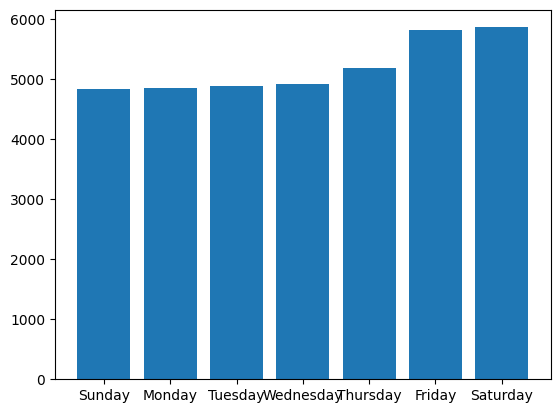

In [38]:
query  = "SELECT COUNT(DISTINCT(id)) as num_crashes, day_of_week_name FROM `traffic_fatalities.traffic_features` GROUP BY day_of_week_name ORDER BY num_crashes"

day = pd.read_gbq(query, project_id=project_id, dialect='standard')

plt.bar(day["day_of_week_name"], day["num_crashes"])

## Number of Crashes by Hour

,num_crashes,hour_of_crash_name
0,1571,0:00am-0:59am
1,1277,1:00am-1:59am
2,1194,2:00am-2:59am
3,1014,3:00am-3:59am
4,1093,4:00am-4:59am
5,1502,5:00am-5:59am
6,1734,6:00am-6:59am
7,930,7:00am-7:59am
8,627,8:00am-8:59am
9,668,9:00am-9:59am


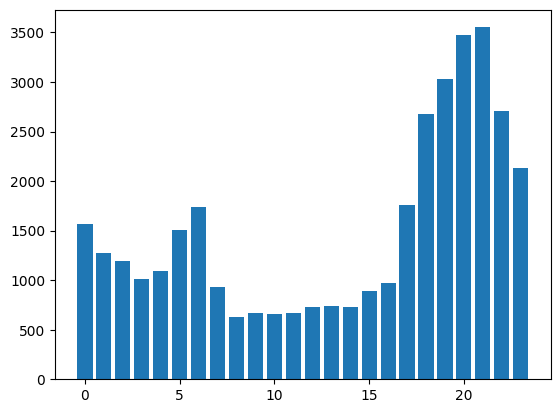

In [6]:
query  = "SELECT COUNT(DISTINCT(id)) as num_crashes, hour_of_crash_name FROM `traffic_fatalities.traffic_features` GROUP BY hour_of_crash_name ORDER BY CASE WHEN hour_of_crash_name = '0:00am-0:59am' THEN 0 WHEN hour_of_crash_name = '1:00am-1:59am' THEN 1 WHEN hour_of_crash_name = '2:00am-2:59am' THEN 2 WHEN hour_of_crash_name = '3:00am-3:59am' THEN 3 WHEN hour_of_crash_name = '4:00am-4:59am' THEN 4 WHEN hour_of_crash_name = '5:00am-5:59am' THEN 5 WHEN hour_of_crash_name = '6:00am-6:59am' THEN 6 WHEN hour_of_crash_name = '7:00am-7:59am' THEN 7 WHEN hour_of_crash_name = '8:00am-8:59am' THEN 8 WHEN hour_of_crash_name = '9:00am-9:59am' THEN 9 WHEN hour_of_crash_name = '10:00am-10:59am' THEN 10 WHEN hour_of_crash_name = '11:00am-11:59am' THEN 11 WHEN hour_of_crash_name = '12:00pm-12:59pm' THEN 12 WHEN hour_of_crash_name = '1:00pm-1:59pm' THEN 13 WHEN hour_of_crash_name = '2:00pm-2:59pm' THEN 14 WHEN hour_of_crash_name = '3:00pm-3:59pm' THEN 15 WHEN hour_of_crash_name = '4:00pm-4:59pm' THEN 16 WHEN hour_of_crash_name = '5:00pm-5:59pm' THEN 17 WHEN hour_of_crash_name = '6:00pm-6:59pm' THEN 18 WHEN hour_of_crash_name = '7:00pm-7:59pm' THEN 19 WHEN hour_of_crash_name = '8:00pm-8:59pm' THEN 20 WHEN hour_of_crash_name = '9:00pm-9:59pm' THEN 21 WHEN hour_of_crash_name = '10:00pm-10:59pm' THEN 22 WHEN hour_of_crash_name = '11:00pm-11:59pm' THEN 23 END"

hours = pd.read_gbq(query, project_id=project_id, dialect='standard')

x = [i for i in range(24)]
plt.bar(x, hours["num_crashes"])
hours

## Top 10 Cities with highest number of Crashes

,num_crashes,city_name
0,740,LOS ANGELES
1,486,PHOENIX
2,431,HOUSTON
3,313,DALLAS
4,296,SAN ANTONIO
5,269,CHICAGO
6,255,JACKSONVILLE
7,213,PHILADELPHIA
8,204,SAN DIEGO
9,202,MEMPHIS


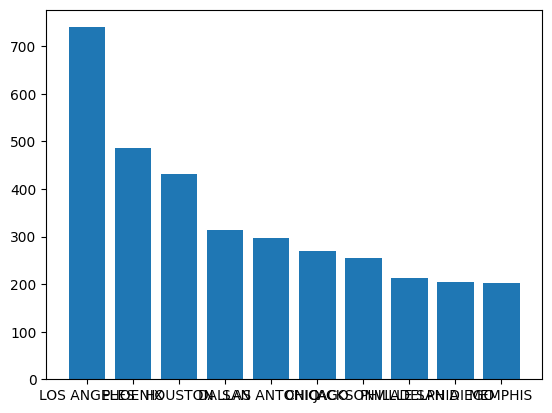

In [8]:
query  = "SELECT COUNT(DISTINCT(id)) as num_crashes, city_name FROM `traffic_fatalities.traffic_features` WHERE city_name != 'NOT APPLICABLE' AND city_name != 'Not Reported' GROUP BY city_name ORDER BY num_crashes DESC LIMIT 10"
city = pd.read_gbq(query, project_id=project_id, dialect='standard')
plt.bar(city["city_name"], city["num_crashes"])
city

## Percent of Crashes where Driver is drunk by Hour

,percent_drunk,num_crashes,hour_of_crash_name
0,10.478873,1571,0:00am-0:59am
1,13.260424,1277,1:00am-1:59am
2,16.559600,1194,2:00am-2:59am
3,10.368466,1014,3:00am-3:59am
4,5.620609,1093,4:00am-4:59am
5,2.616927,1502,5:00am-5:59am
6,2.021223,1734,6:00am-6:59am
7,2.973241,930,7:00am-7:59am
8,1.769912,627,8:00am-8:59am
9,1.871658,668,9:00am-9:59am


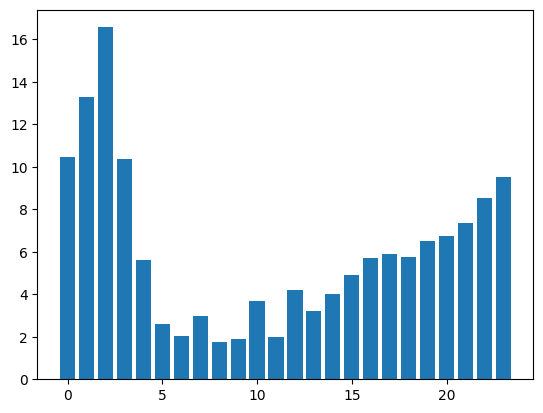

In [73]:
query  = "SELECT SUM(number_of_drunk_drivers)/SUM(number_of_motor_vehicles_in_transport_mvit) * 100 as percent_drunk, COUNT(id) AS num_crashes, hour_of_crash_name FROM (SELECT DISTINCT id, number_of_drunk_drivers, hour_of_crash_name, number_of_motor_vehicles_in_transport_mvit FROM `traffic_fatalities.traffic_features`) GROUP BY hour_of_crash_name ORDER BY CASE WHEN hour_of_crash_name = '0:00am-0:59am' THEN 0 WHEN hour_of_crash_name = '1:00am-1:59am' THEN 1 WHEN hour_of_crash_name = '2:00am-2:59am' THEN 2 WHEN hour_of_crash_name = '3:00am-3:59am' THEN 3 WHEN hour_of_crash_name = '4:00am-4:59am' THEN 4 WHEN hour_of_crash_name = '5:00am-5:59am' THEN 5 WHEN hour_of_crash_name = '6:00am-6:59am' THEN 6 WHEN hour_of_crash_name = '7:00am-7:59am' THEN 7 WHEN hour_of_crash_name = '8:00am-8:59am' THEN 8 WHEN hour_of_crash_name = '9:00am-9:59am' THEN 9 WHEN hour_of_crash_name = '10:00am-10:59am' THEN 10 WHEN hour_of_crash_name = '11:00am-11:59am' THEN 11 WHEN hour_of_crash_name = '12:00pm-12:59pm' THEN 12 WHEN hour_of_crash_name = '1:00pm-1:59pm' THEN 13 WHEN hour_of_crash_name = '2:00pm-2:59pm' THEN 14 WHEN hour_of_crash_name = '3:00pm-3:59pm' THEN 15 WHEN hour_of_crash_name = '4:00pm-4:59pm' THEN 16 WHEN hour_of_crash_name = '5:00pm-5:59pm' THEN 17 WHEN hour_of_crash_name = '6:00pm-6:59pm' THEN 18 WHEN hour_of_crash_name = '7:00pm-7:59pm' THEN 19 WHEN hour_of_crash_name = '8:00pm-8:59pm' THEN 20 WHEN hour_of_crash_name = '9:00pm-9:59pm' THEN 21 WHEN hour_of_crash_name = '10:00pm-10:59pm' THEN 22 WHEN hour_of_crash_name = '11:00pm-11:59pm' THEN 23 END"

drunk = pd.read_gbq(query, project_id=project_id, dialect='standard')

x = [i for i in range(24)]
plt.bar(x, drunk["percent_drunk"])
drunk

## Contributing Circumstances to Crashes Ranked

In [85]:
query  = "SELECT COUNT(id) as num_crashes, contributing_circumstances_motor_vehicle_name FROM `traffic_fatalities.traffic_features` GROUP BY contributing_circumstances_motor_vehicle_name ORDER BY num_crashes DESC"
factor = pd.read_gbq(query, project_id=project_id, dialect='standard')
factor

,num_crashes,contributing_circumstances_motor_vehicle_name
0,36306160,None
1,2356942,None Noted
2,397197,Reported as Unknown
3,176259,Not Reported
4,175935,Other
5,99837,Unknown
6,70360,Tires
7,42849,Head Lights
8,42834,Other Lights
9,41635,Signal Lights


## Driver Impairments Contributing to Crashes Ranked

In [86]:
query  = "SELECT COUNT(id) as num_crashes, condition_impairment_at_time_of_crash_driver_name FROM `traffic_fatalities.traffic_features` GROUP BY condition_impairment_at_time_of_crash_driver_name ORDER BY num_crashes DESC"
drimpair = pd.read_gbq(query, project_id=project_id, dialect='standard')
drimpair

,num_crashes,condition_impairment_at_time_of_crash_driver_name
0,33198456,None/Apparently Normal
1,2759845,"Under the Influence of Alcohol, Drugs or Medic..."
2,1775843,Not Reported
3,1297998,No Driver Present/Unknown if Driver Present
4,328291,Reported as Unknown if Impaired
5,281216,Unknown if Impaired
6,39165,Other Physical Impairment
7,25657,"Ill, Blackout"
8,25290,Impaired Due to Previous Injury
9,8843,Asleep or Fatigued


## Atmospheric Conditions contributing to Crashes Ranked

In [87]:
query  = "SELECT COUNT(id) as num_crashes, atmospheric_conditions_name FROM `traffic_fatalities.traffic_features` GROUP BY atmospheric_conditions_name ORDER BY num_crashes DESC"
atmos = pd.read_gbq(query, project_id=project_id, dialect='standard')
atmos

,num_crashes,atmospheric_conditions_name
0,34918404,Clear
1,3319927,Cloudy
2,993201,Rain
3,328085,Freezing Rain or Drizzle
4,92962,Not Reported
5,58566,Snow
6,25054,"Fog, Smog, Smoke"
7,4902,Blowing Snow
8,3784,Sleet or Hail
9,2021,Reported as Unknown


## Percent of Severe Crashes Given Atmospheric Condition Present

In [98]:
%%bigquery --project $project_id

SELECT SUM(label)/COUNT(*) AS percent_severe, SUM(label) AS num_severe, atmospheric_conditions_name
FROM (SELECT DISTINCT id, label, atmospheric_conditions_name FROM `traffic_fatalities.traffic_features`)
GROUP BY atmospheric_conditions_name
ORDER BY percent_severe

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,percent_severe,num_severe,atmospheric_conditions_name
0,0.029412,1,Unknown
1,0.051282,2,Other
2,0.063830,6,Reported as Unknown
3,0.119959,235,Not Reported
4,0.132300,3430,Clear
5,0.145189,418,Rain
6,0.153652,730,Cloudy
7,0.161644,59,"Fog, Smog, Smoke"
8,0.225806,7,Severe Crosswinds
9,0.259669,47,Snow


## Driver Distractions contributing to Crashes Ranked

In [75]:
query  = "SELECT COUNT(DISTINCT(id)) as num_crashes, driver_distracted_by_name FROM `traffic_fatalities.traffic_features` GROUP BY driver_distracted_by_name ORDER BY num_crashes DESC"
drimpair = pd.read_gbq(query, project_id=project_id, dialect='standard')
drimpair

,num_crashes,driver_distracted_by_name
0,16631,Not Distracted
1,12711,Not Reported
2,2504,Reported as Unknown if Distracted
3,1961,Unknown if Distracted
4,1032,No Driver Present/Unknown if Driver present
5,854,"Inattention (Inattentive), Details Unknown"
6,398,Distraction/Inattention
7,362,"Distracted by Outside Person, Object or Event"
8,316,"Distraction (Distracted), Details Unknown"
9,289,Looked But Did Not See


## Whether Driver Maneuvered to Avoid an Object and What that Object was Ranked by Average Severity

In [76]:
%%bigquery --project $project_id

SELECT COUNT(driver_maneuvered_to_avoid_name) AS num_reports, AVG(severity) AS avg_severity, driver_maneuvered_to_avoid_name
FROM `traffic_fatalities.traffic_features`
GROUP BY driver_maneuvered_to_avoid_name
ORDER BY avg_severity

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,num_reports,avg_severity,driver_maneuvered_to_avoid_name
0,1241,8.728445,Live Animal
1,31308,10.457167,Unknown
2,98313,12.734491,Reported as Unknown
3,6445,13.615516,Object
4,362189,13.995795,"Pedestrian, Pedalcyclist or Other Non-Motorist"
5,64536,14.243446,Phantom/Non-Contact Motor Vehicle
6,1285693,15.920325,No Driver Present/Unknown if Driver present
7,442275,17.101272,Contact Motor Vehicle (In this crash)
8,163874,19.997681,"Poor Road Conditions (Puddle, Ice, Pothole, etc.)"
9,3245351,31.197763,Motor Vehicle


## Severity Ranked by Average Time to Scene

In [63]:
%%bigquery --project $project_id

SELECT severity, COUNT(severity) AS count, AVG(time_to_scene) AS avg_time_to_scene
FROM (SELECT DISTINCT id, severity, time_to_scene FROM `traffic_fatalities.traffic_features` WHERE time_to_scene != 9999)
GROUP BY severity
ORDER BY severity

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,severity,count,avg_time_to_scene
0,6,12058,14.448914
1,7,329,19.747720
2,8,961,16.548387
3,9,55,17.345455
4,10,329,16.118541
5,11,24,21.958333
6,12,78,17.923077
7,13,7,44.714286
8,14,37,22.621622
9,15,7,9.857143


## Number of Fatalities Ranked by Average time to Scene

In [62]:
%%bigquery --project $project_id

SELECT number_of_fatalities, COUNT(number_of_fatalities) AS count, AVG(time_to_scene) AS avg_time_to_scene
FROM (SELECT DISTINCT id, number_of_fatalities, time_to_scene FROM `traffic_fatalities.traffic_features` WHERE time_to_scene != 9999)
GROUP BY number_of_fatalities
ORDER BY number_of_fatalities

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,number_of_fatalities,count,avg_time_to_scene
0,1,13683,14.801506
1,2,210,17.528571
2,3,21,14.428571
3,4,2,5.000000
4,5,1,2.000000
5,20,1,68.000000


## Violations given to Driver Ranked by Average Severity

In [77]:
%%bigquery --project $project_id

SELECT violations_charged_name, COUNT(violations_charged_name) AS count, AVG(severity) AS avg_severity
FROM `traffic_fatalities.traffic_features`
GROUP BY violations_charged_name
ORDER BY avg_severity

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,violations_charged_name,count,avg_severity
0,Fail to give way when overtaken,6,6.000000
1,Turn in violation of traffic control (disobey ...,6,6.000000
2,Lamp violations,24,6.000000
3,Fail to obey yield sign,1,6.000000
4,Pass stopped school bus,4,6.000000
...,...,...,...
62,Non-moving violations generally,62412,20.624880
63,"Fail to obey police, fireman, authorized perso...",28132,21.996019
64,None,33120116,31.203712
65,Driving while intoxicated (alcohol or drugs) o...,2365920,34.920075


## Number of Fatalities per state Ranked by Average Time to Scene

In [78]:
%%bigquery --project $project_id

SELECT state_name, SUM(number_of_fatalities) AS total_fatalities, COUNT(state_name) AS num_crashes, AVG(time_to_scene) AS avg_time_to_scene
FROM (SELECT DISTINCT id, state_name, number_of_fatalities, time_to_scene FROM `traffic_fatalities.traffic_features` WHERE time_to_scene != 9999)
GROUP BY state_name
ORDER BY avg_time_to_scene

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,state_name,total_fatalities,num_crashes,avg_time_to_scene
0,District of Columbia,32,31,9.580645
1,Rhode Island,75,75,9.586667
2,Nevada,167,165,10.375758
3,Massachusetts,356,352,10.446023
4,Illinois,279,275,10.712727
5,Alabama,455,449,10.868597
6,New Jersey,635,626,11.968051
7,Vermont,30,30,12.133333
8,Colorado,369,368,12.472826
9,Ohio,774,758,12.609499


## Number of Fatalities per State Ranked by Average Time to Hospital

In [70]:
%%bigquery --project $project_id

SELECT state_name, SUM(number_of_fatalities) AS total_fatalities, COUNT(state_name) AS num_crashes, AVG(time_to_hospital) AS avg_time_to_hospital
FROM (SELECT DISTINCT id, state_name, number_of_fatalities, time_to_hospital FROM `traffic_fatalities.traffic_features` WHERE time_to_hospital != 9999)
GROUP BY state_name
ORDER BY avg_time_to_hospital

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,state_name,total_fatalities,num_crashes,avg_time_to_hospital
0,Florida,2,2,18.000000
1,Illinois,1,1,26.000000
2,Alaska,24,24,37.708333
3,South Dakota,20,20,44.800000
4,Nevada,136,134,45.679104
5,New Mexico,99,97,45.948454
6,Colorado,223,223,46.565022
7,Nebraska,53,52,47.615385
8,Arizona,575,560,49.132143
9,Utah,82,80,50.162500


## Training Time

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `traffic_fatalities.traffic_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
    state_name,
    number_of_motor_vehicles_in_transport_mvit,
    number_of_parked_working_vehicles,
    number_of_persons_in_motor_vehicles_in_transport_mvit,
    number_of_persons_not_in_motor_vehicles_in_transport_mvit,
    city_name,
    day_name,
    month_of_crash_name,
    day_of_week_name,
    hour_of_crash_name,
    route_signing_name,
    land_use_name,
    first_harmful_event_name,
    work_zone_name,
    relation_to_trafficway_name,
    light_condition_name,
    atmospheric_conditions_name,
    time_to_scene,
    time_to_hospital,
    number_of_drunk_drivers,
    label,
    driver_distracted_by_name,
    condition_impairment_at_time_of_crash_driver_name,
    contributing_circumstances_motor_vehicle_name,
    driver_maneuvered_to_avoid_name,
    non_motorist_contributing_circumstances_name,
    condition_impairment_at_time_of_crash_non_motorist_name,
    violations_charged_name,
    drivers_vision_obscured_by_name
FROM `traffic_fatalities.traffic_features`
LIMIT 31799040